In [78]:
import ast
import math
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [63]:
scans = pd.read_csv('scan.csv', header=None, delimiter=' ').iloc[:, :-1]
def convert_to_xy(point_str):
    x, y = ast.literal_eval(point_str)
    return [x, y]
scans = scans.applymap(convert_to_xy)
points = np.array(scans.values.tolist())
points.shape

(65, 1081, 2)

In [64]:
df = pd.read_csv('transformation.csv', header=None).iloc[:, :-1]
trans = np.reshape(df, (-1, 4, 4))
trans.shape

(65, 4, 4)

In [65]:
def homogenous(scan):
    n = scan.shape[0]
    zeros_column = np.zeros((n, 1))
    ones_column = np.ones((n, 1))
    return np.hstack((scan, zeros_column, ones_column))

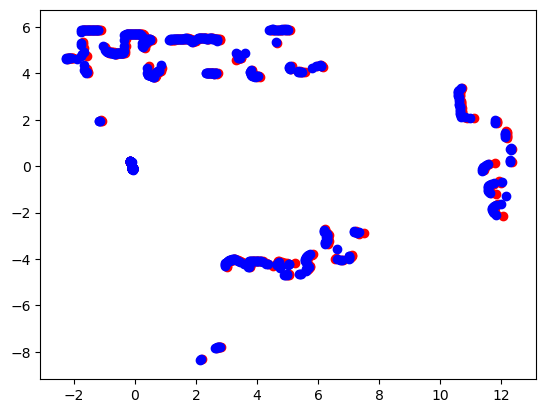

In [66]:
idx = 11
prior = points[idx]
prior = prior[np.linalg.norm(prior, axis = 1) < 20]
post = points[idx + 1]
post = post[np.linalg.norm(post, axis = 1) < 20]
prior = homogenous(prior)
s = prior @ trans[idx + 1]
plt.scatter(*s[:, :2].T, c='r')
plt.scatter(*post[:, :2].T, c='b')

In [67]:
df_t  = trans[:, :2, 3]
pd.DataFrame(df_t).describe()

,0,1
count,65.000000,65.000000
mean,0.084989,-0.004328
std,0.056528,0.023524
min,-0.002430,-0.143456
25%,0.058606,-0.004783
50%,0.073721,-0.000822
75%,0.092330,0.004806
max,0.306371,0.030407


In [68]:
with open("optimized_poses.csv", 'r') as file:
    lines = file.readlines()
data = [line.strip('()\n').split(', ') for line in lines]
pose_graph = np.array(data, dtype=float)

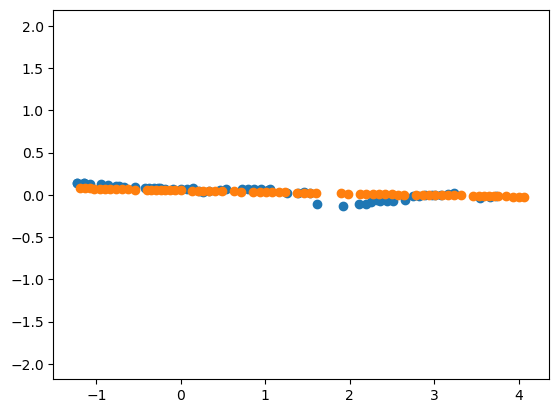

In [69]:
plt.axis('equal')
plt.scatter(*pose_graph[:, :2].T)


raw_traj = np.loadtxt("location.csv", delimiter=",")
plt.scatter(*raw_traj[:, :2].T)

In [35]:
print(trans.shape)
print(loc.shape)
print(pose_graph.shape)
print(scans.shape)

(67, 4, 4)
(67, 6)
(61, 3)
(67, 1081)


In [70]:
def se2_transform(x, y, theta):
    """
    Create a 3x3 transformation matrix for SE(2) points.
    
    Args:
    x (float): Translation along the x-axis.
    y (float): Translation along the y-axis.
    theta (float): Rotation angle in radians.
    
    Returns:
    numpy.array: 3x3 transformation matrix.
    """
    # Construct the rotation matrix
    rotation_matrix = np.array([
        [math.cos(theta), -math.sin(theta)],
        [math.sin(theta), math.cos(theta)],
    ])
    
    # Construct the translation vector
    translation_vector = np.array([
        [x],
        [y]
    ])
    
    # Construct the homogeneous transformation matrix
    transformation_matrix = np.hstack((rotation_matrix, translation_vector))
    bottom_row = np.array([0, 0, 1])
    transformation_matrix = np.vstack((transformation_matrix, bottom_row))
    
    return transformation_matrix


In [71]:
points.shape

(65, 1081, 2)

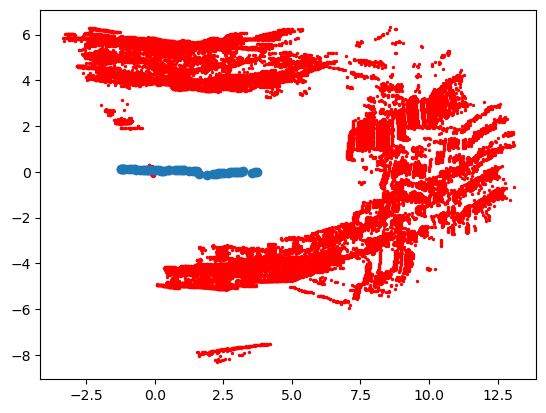

In [82]:
for i in range(pose_graph.shape[0]):
  scan = points[i]
  scan = scan[np.linalg.norm(scan, axis=1) < 20]
  opt_loc = pose_graph[i][:3]
  T = se2_transform(*opt_loc)
  n = scan.shape[0]
  scan = np.hstack((scan, np.ones((n, 1))))
  plt.scatter(*(scan @ T)[:, :2].T, c='r', s=2)

plt.scatter(*pose_graph[:, :2].T)
  